## 09_mTRF_analysis

**What is mTRF?**

mTRF stands for "multivariate temporal receptive field." It is an attempt to describe what stimuli excite or inhibit a neuron, or population of neurons, over time. It is developed from STRF which stands for "spectrotemporal receptive field," expanded to work with all stimulus features, not just spectrotemporal ones.

* m(ultivariate) = works with all stimulus types
* T(emporal) = describes the response over time
* R(eceptive) = describes how neurons are excited or inhibited
* F(ield) = describes what stimuli excite or inhibit

Here are some visual examples of mTRFs (technically this first one is a STRF, but STRFs are a subset of mTRFs):

<center><img src="https://upload.wikimedia.org/wikipedia/commons/7/75/Spectro-temporal_receptive_field_%28auditory_neuron_of_zebra_finch%29.jpg"> </center>

Here we see a neuron which is excited by frequencies in the 3-7Hz range at 10-11ms post stimulus presentation, then inhibited by that same frequency range 15-20ms post stimulus presentation. This pattern of activation is indicative of an "edge detector" neuron, one that likes rapid temporal changes in frequency.

<center><img src="https://puu.sh/HPtgf/17480ffe3d.png"></center>

This is an example of a different feature space. This is a population of neurons (ECoG recording) that is excited and inhibited by different phonological features.

## The power of mTRF
mTRF is an example of a subset of machine learning techniques called an _encoding model_. It is an attempt to predict neural activity based on stimulus information. This is the opposite of a _decoding model_ where you try to predict the stimulus information based on the neural activity.

Here are some examples:

* [nVidia gaugan](http://nvidia-research-mingyuliu.com/gaugan)-- the stimulus features are the lines you draw, and the response is the image representation.
* SIRI is a decoding model, which takes the response (audio) and tries to segment it into the stimulus features (words/questions).

This is awesome because it gives an approach with a lot of computational and statistical power, and lets us ask questions about the structure of our data that we wouldn't be able to do with conventional statistical methods. However, it's complicated, and unless you're a statistician or computer scientist, chances are you didn't grow up learning how to conduct and interpret mTRF analysis (like me). The important thing to know about mTRF is that your **stimulus selection is very important, and in a lot of ways functions like the hypothesis of your experiment**. We can fit an infinite number of stimulus spaces to a single dataset, and it is our discretion as researchers to decide how to do this! This brings a lot of bias into the model in the sense that we will fit models that we think capture the structure of the data in some way. So just, be careful when selecting your stimulus features! (Also for this notebook we won't be tackling this problem for the sake of simplicity)

For more information on the encoding/decoding framework, check out [this paper](https://www.frontiersin.org/articles/10.3389/fnsys.2017.00061/full).

## The model we will fit in this notebook
We will be fitting a model using some EEG data from my thesis experiement, the same dataset we've been doing everything in the lab intro notebooks with.

* The response: 64 channel EEG of a participant reading sentences and listening to playback of themselves reading those sentences.
* The stimulus: three features: acoustic envelope (remember our audio preprocessing notebook?), then two binary features for consonant and vowel. That means, 1 if it's a cons or vowel, and 0 if it isn't. This gives us a total of 3 features (env, cons binary, vow binary) in our encoding model.

In [1]:
import mne
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm, rcParams
import re
from supplemental_files import textgrid
from supplemental_files.strf.strf import strf
import csv
import scipy
from scipy.io import wavfile
from scipy.signal import hilbert, butter, filtfilt, resample

In [2]:
# Some helper functions
def is_cons(transcript):
    '''
    Determine if a phonemic transcript is a consonant.
    Returns:
    * 0 if not consonant
    * 1 if consonant
    '''
    if "0" in transcript: # vowels contain numbers to mark stress
        return 0
    elif "1" in transcript:
        return 0
    elif "2" in transcript:
        return 0
    else:
        return 1
def is_vow(transcript):
    '''
    Determine if a phonemic transcript is a vowel.
    Returns:
    * 0 if not vowel
    * 1 if vowel
    '''
    if "0" in transcript: # vowels contain numbers to mark stress
        return 1
    elif "1" in transcript:
        return 1
    elif "2" in transcript:
        return 1
    else:
        return 0

## Step 1: Get the stimulus and the response

In [3]:
# Load raw
# REMEMBER: CHANGE THIS FPATH IF YOU ARE FOLLOWING ALONG AT HOME
raw_fpath = 'F:/Desktop/example_preprocessed_data.fif'
raw = mne.io.read_raw_fif(raw_fpath,preload=True,verbose=False)

<ipython-input-3-7c4d20b2bf0a>:4: RuntimeWarning: This filename (F:/Desktop/example_preprocessed_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw = mne.io.read_raw_fif(raw_fpath,preload=True,verbose=False)


In [4]:
# Load event file (this is how we get our C/V stimuli)
sfreq = 128
event_file = []
ev_fpath = "./supplemental_files/phoneme_event_file.txt"
with open(ev_fpath,'r') as csvfile:
    csvReader = csv.reader(csvfile,delimiter="\t")
    for row in csvReader:
        onset = int(np.round(float(row[0])*sfreq))
        offset = int(np.round(float(row[1])*sfreq))
        transcript = row[3]
        # These help prevent "double dipping" later on...
        rep = int(row[4]) # how many times they've read a sentence
        sn_id = int(row[5]) # which sentence the phoneme is from
        event_file.append([onset,offset,transcript,rep,sn_id])

In [5]:
# Get audio envelope (this is how we get our env stimulus)
# Code taken from audio_tools.py
def get_envelope(audio, audio_fs, new_fs, cof=25, bef_aft=[0, 0], pad_next_pow2=False):
    ''' Get the envelope of a sound file
    Inputs:
        w [float] : audio signal vector
        fs [int] : sampling rate of audio signal
        new_fs [int] : desired sampling rate of the envelope (same as your EEG, for example)
    Outputs:
        envelope [array-like] : returns the envelope of the sound as an array
    '''
    
    if pad_next_pow2:
        print("Padding the signal to the nearest power of two...this should speed things up")
        orig_len = len(audio)
        sound_pad = np.hstack((audio, np.zeros((2**np.int(np.ceil(np.log2(len(audio))))-len(audio),))))
        audio = sound_pad

    print("calculating hilbert transform")
    env_hilb = np.abs(hilbert(audio))

    nyq = audio_fs/2. #Nyquist frequency
    b, a = butter(3, cof/nyq, 'low'); #this designs a 3-pole low-pass filter
    
    print("Low-pass filtering hilbert transform to get audio envelope")
    envelope_long = np.atleast_2d(filtfilt(b, a, env_hilb, axis=0)) #filtfilt makes it non-causal (fwd/backward)

    envelope = resample(envelope_long.T, np.int(np.floor(envelope_long.shape[1]/(audio_fs/new_fs))))
    if pad_next_pow2:
        print("Removing padding")
        final_len = np.int((orig_len/audio_fs)*new_fs)
        envelope = envelope[:final_len,:]
        print(envelope.shape)

    if bef_aft[0] < 0:
        print("Adding %.2f seconds of silence before"%bef_aft[0])
        envelope = np.vstack(( np.zeros((np.int(np.abs(bef_aft[0])*new_fs), 1)), envelope ))
    if bef_aft[1] > 0:
        print("Adding %.2f seconds of silence after"%bef_aft[1])
        envelope = np.vstack(( envelope, np.zeros((np.int(bef_aft[1]*new_fs), 1)) ))

    return envelope

In [6]:
# Get envelope
# Change this path if you're following along at home
# May take a while to run
wav_fpath = 'F:/Desktop/full_block_audio.wav'
sfreq, audio = wavfile.read(wav_fpath)
env = get_envelope(audio, sfreq, 128)
print(env.shape)

calculating hilbert transform
Low-pass filtering hilbert transform to get audio envelope


<ipython-input-5-4cb3a7996cc0>:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  envelope = resample(envelope_long.T, np.int(np.floor(envelope_long.shape[1]/(audio_fs/new_fs))))


(736919, 1)


In [7]:
# Create response matrix
eeg_chs = mne.pick_types(raw.info,meg=False,eog=False,eeg=True)
resp = raw.get_data(picks=eeg_chs).T
n_samps = resp.shape[0]
print(resp.shape) # samps x chs

# Also, we need to clip the envelope so it's the same length as the response.
# This is likely some random rounding error
if env.shape[0] > resp.shape[0]:
    env = env[:resp.shape[0]] # just cut off the last few samples
    print(env.shape)

(736915, 64)
(736915, 1)


In [8]:
# Create stimulus matrix
features = ["env","cons","vow"]
stim = np.zeros((n_samps,len(features))) 
for i, samp in enumerate(event_file):
    onset = samp[0]
    offset = samp[1]
    c = is_cons(samp[2])
    v = is_vow(samp[2])
    rep = samp[3]
    sn_id = samp[4]
    stim[onset,1] = c
    stim[onset,2] = v
stim[:,0] = env[:,0]/env[:,0].max() # normalize envelope so the max is 1
print(stim.shape) # samps x features

(736915, 3)


<ipython-input-9-e31b251ab68f>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  t_start = np.int(2500*128)
<ipython-input-9-e31b251ab68f>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more detail

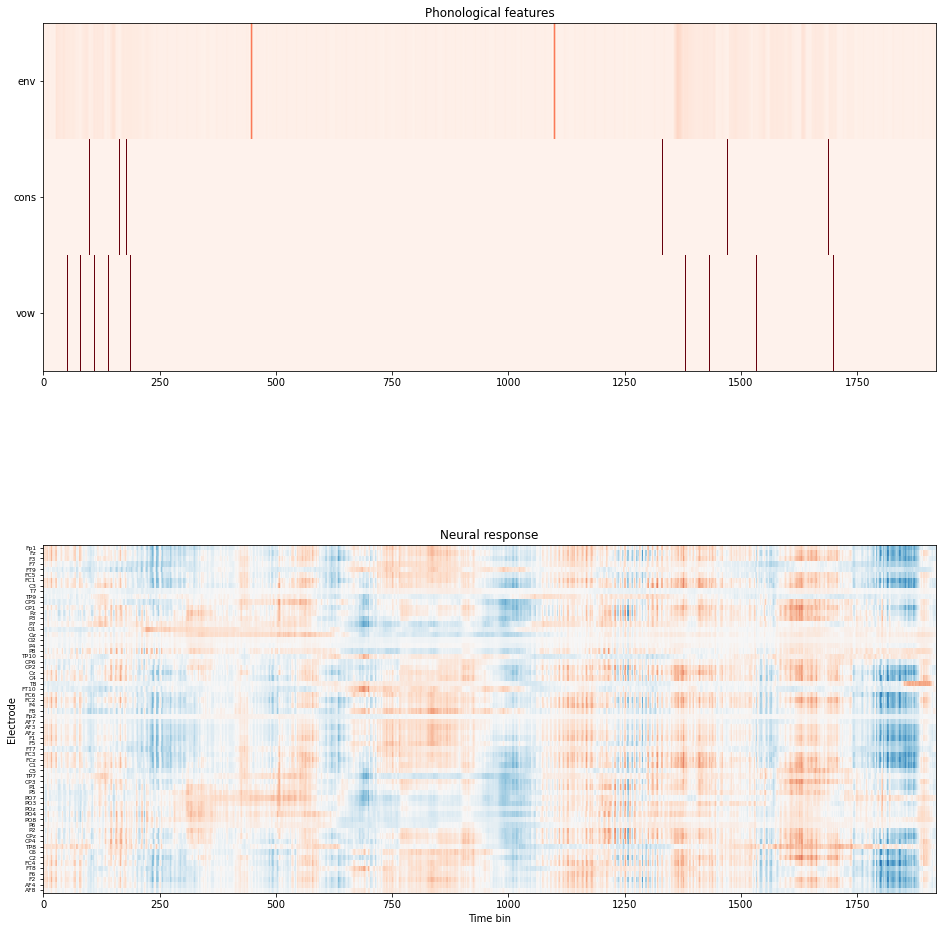

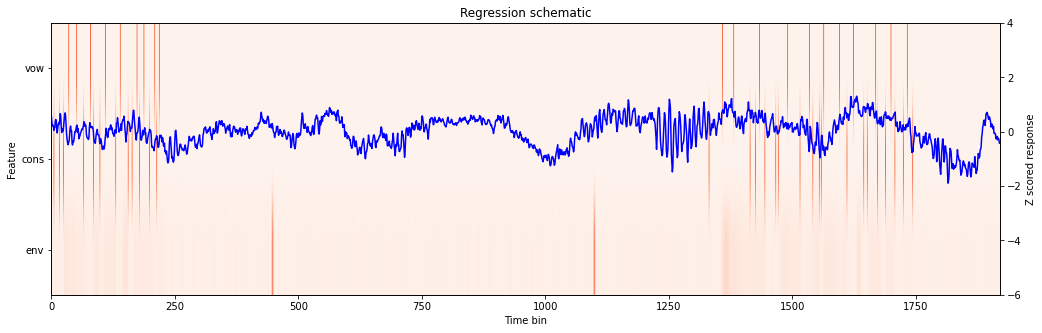

In [9]:
# Regression schematic
# Plot stim & resp
fig, axes = plt.subplots(figsize=(16,16)) # make a figure of size 12 x 8

# Subplot 1: show binary features (stimulus)
ax = fig.add_subplot(2,1,1)
t_start = np.int(2500*128)
t_end = np.int(2515*128)
plt.imshow(stim[t_start:t_end,:].T, aspect='auto',interpolation="nearest",cmap=cm.Reds);
plt.gca().set_yticks(np.arange(3))
plt.gca().set_yticklabels(features)
plt.title('Phonological features')
#plt.gca().set_ylim([-0.5, 28.5])
 
# Subplot 2: show the EEG (response)
plt.subplot(2,1,2)
zs = lambda x: (x-x.mean(0))/x.std(0) # z scoring it
zs_resp = zs(resp)
rmax = np.max(np.abs(zs_resp))*0.1
plt.imshow(zs_resp[t_start:t_end,:].T, vmin=-rmax, vmax=rmax, cmap = cm.RdBu_r, aspect='auto', interpolation = 'nearest') 
plt.ylabel('Electrode')
plt.xlabel('Time bin')
plt.gca().set_yticks(np.arange(len(raw.info['ch_names'])))
plt.gca().set_yticklabels(raw.info['ch_names'],fontsize=6)
plt.title('Neural response')
fig.subplots_adjust(hspace=.5) # Put some space between the plots for ease of viewing
# Set some parameters for this and future plots
rcParams['font.family'] = 'sans-serif'
rcParams['text.usetex'] = False
rcParams['axes.labelsize'] = 10
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['legend.fontsize'] = 10

# Subplot 3: Regression schematic
fig = plt.figure(figsize=(17,5))
ax1 = fig.add_subplot(111)
ax1.imshow(stim[t_start:t_end,:].T, cmap = cm.Reds, aspect='auto')
plt.xlabel('Time bin')
ax1.set_ylim(ax.get_ylim()[::-1]) # This just reverses the y axis so low frequency is at the bottom
ax1.set_ylabel('Feature')
ax1.set_yticks(np.arange(len(features)))
ax1.set_yticklabels(features)
ax1.set_xlim(0,t_end-t_start)
# Plot the response overlayed (with a separate y axis scaled appropriately)
ax2 = ax1.twinx()
ax2.plot(zs_resp[t_start:t_end,:].mean(1), 'b') 
ax2.set_ylabel('Z scored response', color='k')
for tl in ax2.get_yticklabels():
    tl.set_color('k')
ax2.set_xlim(0,t_end-t_start);
ax2.set_ylim(-6, 4)
plt.title('Regression schematic');


## Step 2: Split stim and resp into training and validation sets
In this example, we have 100 sentences in the dataset. We will train on 80 of these sentences then test our model on the remaining 20 sentences. This code splits those 100 sentences into train/validation sets, paying special attention to not include one sentence in both sets, because that would be "cheating" the model.

In [10]:
# Now that we have stim and resp we need to split them into training and validation sets.
            
# Step 1: read sentence event file
sen_onset,sen_offset,sen_id = [],[],[]
ev_fname = './supplemental_files/sentence_event_file.txt'
with open(ev_fname,'r') as my_csv:
    csvReader = csv.reader(my_csv,delimiter='\t')
    for row in csvReader:
        sen_onset.append(float(row[0]))
        sen_offset.append(float(row[1]))
        sen_id.append(int(row[2]))
        
# Step 2: Make a dict split by unique ID so we don't double dip IDs when splitting
# into training and validation sets
sen_samps = dict() # sample ranges for each unique ID
for unique_idx, unique_id in enumerate(np.unique(sen_id)):
    sen_range = []
    for this_idx, this_id in enumerate(sen_id):
        if this_id == unique_id: # We got a match!
            onset_samp = int(sen_onset[this_idx]*128)
            offset_samp = int(sen_offset[this_idx]*128)
            sen_range.append([onset_samp,offset_samp])
    sen_samps[unique_id] = sen_range
    
# Step 3: match each sentence to the stims and resps arrays created earlier
jitter = 0.5
resp_dict,stim_dict = dict(),dict()
for unique_id in sen_samps.keys():
    resp_matches, stim_matches = [], []
    for unique_idx, times in enumerate(sen_samps[unique_id]):
        onset_samp, offset_samp = times[0], times[1]
        for samp_idx in range(len(resp)):
            if samp_idx >= onset_samp-jitter and samp_idx <= offset_samp+jitter:
                resp_matches.append(resp[samp_idx,:])
                stim_matches.append(stim[samp_idx,:])
    resp_dict[unique_id] = np.array(resp_matches) # samps x chs
    stim_dict[unique_id] = np.array(stim_matches) # samps x feats

# Step 4: split stim and resp dicts into training and validation sets
np.random.seed(6655321)
train_sen_ids = np.random.permutation(list(resp_dict.keys()))[:80]
np.random.seed(6655321)
val_sen_ids = np.random.permutation(list(resp_dict.keys()))[80:]
tStims_by_sen,vStims_by_sen,tResps_by_sen,vResps_by_sen = dict(),dict(),dict(),dict()
# It needs to match with the true sentence id, not where it is in a sequence of 20
# There has to be some clever way to do this... try on Monday or Tuesday
for train_id in train_sen_ids:
    tResps_by_sen[train_id] = resp_dict[train_id]
    tStims_by_sen[train_id] = stim_dict[train_id]
for val_id in val_sen_ids:
    vResps_by_sen[val_id] = resp_dict[val_id]
    vStims_by_sen[val_id] = stim_dict[val_id]
tStim = np.vstack(list(tStims_by_sen.values()))
vStim = np.vstack(list(vStims_by_sen.values()))
tResp = np.vstack(list(tResps_by_sen.values()))
vResp = np.vstack(list(vResps_by_sen.values()))
print(f"Training on {tStim.shape[0]} samples, validating on {vStim.shape[0]} samples. raw contained {resp.shape[0]} samples,")

Training on 109341 samples, validating on 26233 samples. raw contained 736915 samples,


## Step 3: Run the mTRF

In [11]:
# Create delay matrices
# mTRFs run a series of linear regressions on timeshifted (delayed) data, in order to get the "temporal" aspect of the TRF
# It's the timelag between the stimulus happening and the corresponded response.
# Some people conceptualize this as system "memory"
# When selecting delays, you want to incorporate a time range that you theorize your stimuli will elicit a response within
# In this example, we will see responses 300ms before a phoneme and up to 500ms after a phoneme.
delay_min, delay_max = -0.3, 0.5 # The window of interest (in s)
# Create a numpy array that is a range of steps in this time window
delays = np.arange(np.floor(delay_min*128),np.ceil(delay_max*128),dtype=int)

In [12]:
# set number of bootstraps (number of iterations in the strf)
# Basically, run your mTRF this amount of times. If it looks the same each time then your model is stable.
nboots = 10
# Create range of alphas - a fixed parameter in the mTRF that can affect the performance. you may have to play around with it
# More specifically, it's a regularization parameter. The larger the alpha, the smoother your weights will be.
alphas = np.hstack((0,np.logspace(1,5,20)))
# To run the strf, we call a function from supplemental_files/strf.py. Look at this script if you're curious how it works!
corrs, wts, tStim, tResp, vStim, vResp, alphas, pred = strf(tResp, tStim, nboots=nboots, delay_min=delay_min, delay_max=delay_max,
                                                     vResp=vResp, vStim=vStim, flip_resp=True, alphas=alphas, sfreq=128)

64 109341
Delays: [-39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22
 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4
  -3  -2  -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14
  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32
  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50
  51  52  53  54  55  56  57  58  59  60  61  62  63]


INFO:ridge_corr:Selecting held-out test set..
INFO:ridge_corr:Doing Eigenvalue decomposition...
INFO:ridge_corr:Training: alpha=0.000, mean corr=0.12975, max corr=0.27427, over-under(0.05)=50
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.12975, max corr=0.27501, over-under(0.05)=50
INFO:ridge_corr:Training: alpha=16.238, mean corr=0.12990, max corr=0.27531, over-under(0.05)=50
INFO:ridge_corr:Training: alpha=26.367, mean corr=0.13010, max corr=0.27566, over-under(0.05)=50
INFO:ridge_corr:Training: alpha=42.813, mean corr=0.13032, max corr=0.27606, over-under(0.05)=50
INFO:ridge_corr:Training: alpha=69.519, mean corr=0.13056, max corr=0.27644, over-under(0.05)=50
INFO:ridge_corr:Training: alpha=112.884, mean corr=0.13075, max corr=0.27670, over-under(0.05)=50
INFO:ridge_corr:Training: alpha=183.298, mean corr=0.13080, max corr=0.27661, over-under(0.05)=50
INFO:ridge_corr:Training: alpha=297.635, mean corr=0.13052, max corr=0.27580, over-under(0.05)=50
INFO:ridge_corr:Training: alp

INFO:ridge_corr:Training: alpha=8858.668, mean corr=0.11799, max corr=0.36814, over-under(0.05)=40
INFO:ridge_corr:Training: alpha=14384.499, mean corr=0.10970, max corr=0.37975, over-under(0.05)=38
INFO:ridge_corr:Training: alpha=23357.215, mean corr=0.10125, max corr=0.37988, over-under(0.05)=32
INFO:ridge_corr:Training: alpha=37926.902, mean corr=0.09358, max corr=0.37044, over-under(0.05)=28
INFO:ridge_corr:Training: alpha=61584.821, mean corr=0.08728, max corr=0.36749, over-under(0.05)=27
INFO:ridge_corr:Training: alpha=100000.000, mean corr=0.08252, max corr=0.37242, over-under(0.05)=23
INFO:counter:4/10 items complete (1.94 seconds/item, 00:00:11 remaining)
INFO:ridge_corr:Selecting held-out test set..
INFO:ridge_corr:Doing Eigenvalue decomposition...
INFO:ridge_corr:Training: alpha=0.000, mean corr=0.13784, max corr=0.28708, over-under(0.05)=57
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.13750, max corr=0.28794, over-under(0.05)=56
INFO:ridge_corr:Training: alpha=16.238

INFO:ridge_corr:Training: alpha=297.635, mean corr=0.14055, max corr=0.30486, over-under(0.05)=57
INFO:ridge_corr:Training: alpha=483.293, mean corr=0.13891, max corr=0.30404, over-under(0.05)=57
INFO:ridge_corr:Training: alpha=784.760, mean corr=0.13667, max corr=0.30381, over-under(0.05)=56
INFO:ridge_corr:Training: alpha=1274.275, mean corr=0.13374, max corr=0.30492, over-under(0.05)=56
INFO:ridge_corr:Training: alpha=2069.138, mean corr=0.12998, max corr=0.30834, over-under(0.05)=53
INFO:ridge_corr:Training: alpha=3359.818, mean corr=0.12524, max corr=0.31494, over-under(0.05)=52
INFO:ridge_corr:Training: alpha=5455.595, mean corr=0.11923, max corr=0.32470, over-under(0.05)=50
INFO:ridge_corr:Training: alpha=8858.668, mean corr=0.11181, max corr=0.33540, over-under(0.05)=44
INFO:ridge_corr:Training: alpha=14384.499, mean corr=0.10334, max corr=0.34190, over-under(0.05)=41
INFO:ridge_corr:Training: alpha=23357.215, mean corr=0.09470, max corr=0.33911, over-under(0.05)=37
INFO:ridge_

Cmode = False
Number of time points is greater than the number of features
stim shape (not cmode): 
(87472, 309)


INFO:ridge_corr:Computing weights
INFO:ridge_corr:Predicting responses for predictions set..


Covmat shape: 
(309, 309)
(309, 309) (309, 87472) (87472, 64)
wt shape:
(309, 64)
(309, 64)


## Step 4: Tweak your mTRF parameters
There are several (in my opinion) unintuitive aspects of running a mTRF. These are your hyperparameters:

* `nboots` -- the number of times to run your mTRF. This is mostly bottlenecked by your computer's performance, how many "laps" can it "run?" 10 is a good start but if you are having troubles try going lower. Try going to 20 if you think you are big and tough. The number of bootstraps also tells you how stable your model is -- if you are getting similar results with each run, then your model is stable. Yay!
* `alphas` -- this one is tricky. The alpha is a regularization parameter and acts to sort of smooth (or "regularize," i guess) your data. Your best-performing alpha should be right in the middle of your selected logspace. If it's too close to one side of the logarithmic curve, you are either overfitting or underfitting your mTRF. A low alpha will result in pixelated receptive fields while a high alpha will result in over-smoothed receptive fields. 
<center><img src="https://puu.sh/HPKgv/084fe16de2.png"></center>

DEBUG:matplotlib.ticker:vmin 6.309573444801933 vmax 158489.3192461114
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
       1.e+07])
DEBUG:matplotlib.ticker:vmin 6.309573444801933 vmax 158489.3192461114
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
       1.e+07])
DEBUG:matplotlib.ticker:vmin 6.309573444801933 vmax 158489.3192461114
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
       1.e+07])
DEBUG:matplotlib.ticker:vmin 6.309573444801933 vmax 158489.3192461114
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+

16.237767391887218


DEBUG:matplotlib.ticker:vmin 6.309573444801933 vmax 158489.3192461114
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
       1.e+07])
DEBUG:matplotlib.ticker:vmin 6.309573444801933 vmax 158489.3192461114
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
       1.e+07])
DEBUG:matplotlib.ticker:vmin 6.309573444801933 vmax 158489.3192461114
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+0

DEBUG:matplotlib.ticker:vmin 6.309573444801933 vmax 158489.3192461114
DEBUG:matplotlib.ticker:ticklocs array([2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04,
       2.e+05, 3.e+05, 4.e+05, 5.e+05, 6.e+05, 7.e+05, 8.e+05, 9.e+05,
       2.e+06, 3.e+06, 4.e+06, 5.e+06, 6.e+06, 7.e+06, 8.e+06, 9.e+06,
       2.e+07, 3.e+07, 4.e+07, 5.e+07, 6.e+07, 7.e+07, 8.e+07, 9.e+07])
DEBUG:matplotlib.ticker:vmin 6.309573444801933 vmax 158489.3192461114
DEBUG:matplotlib.ticker:ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06,
       1.e+07])
DEBUG:matplotlib.ticker:vmin 6.309573444801933 vmax 158489.31924611

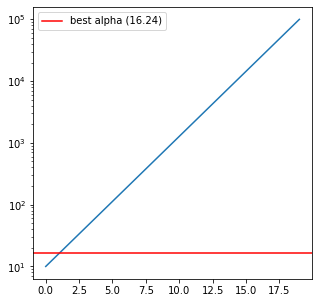

In [14]:
# Alpha selection
plt.figure(figsize=(5,5))
best_alpha = alphas[0]
print(best_alpha)
plt.semilogy(np.logspace(1,5,20));
plt.axhline(best_alpha,color='r',label="best alpha (%.2f)" % best_alpha);
plt.legend();

## Step 5: Evaluate your mTRF performance
There are many ways to do this. Here are a few:

* Look at your predicted vs. actual response. This is a direct measure of how well your model performed, but may not be super informative.
* Look at the contributions of individual weights. This shows you how your feature selection informed your model performance. Remember, the features you select are your hypothesis, so this is a potentially very useful analysis!
* Look at how well your model did versus random chance. To do this, you can perform a bootstrap task. This is nice for getting statistical significance.

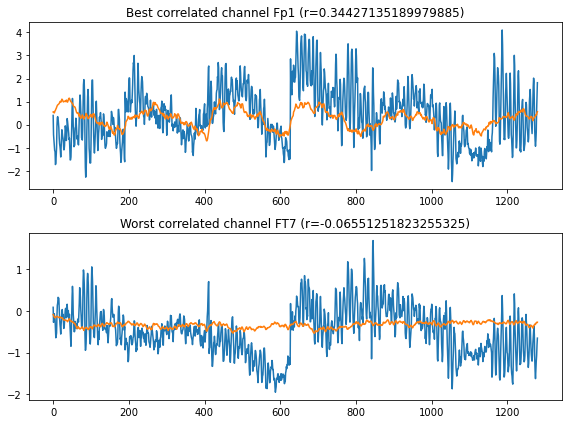

In [15]:
t_start,t_end = 0, 1280
plt.figure(figsize=(8,6))
# Predicted versus actual response for a single channel
plt.subplot(2,1,1)
chan = corrs[0].argmax() # Best correlated channel
plt.plot(vResp[t_start:t_end,chan]);
plt.plot(pred[t_start:t_end,chan])
plt.title(f"Best correlated channel {raw.info['ch_names'][chan]} (r={corrs[0][chan]})", fontsize=12);

plt.subplot(2,1,2)
chan = corrs[0].argmin() # Worst correlated channel
plt.plot(vResp[t_start:t_end,chan]);
plt.plot(pred[t_start:t_end,chan])
plt.title(f"Worst correlated channel {raw.info['ch_names'][chan]} (r={corrs[0][chan]})",fontsize=12);
plt.tight_layout();

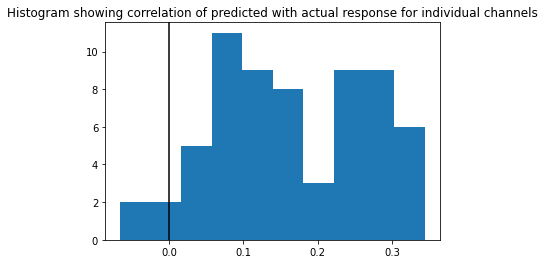

In [16]:
plt.hist(corrs);
plt.axvline(0,color='k')
plt.title("Histogram showing correlation of predicted with actual response for individual channels");

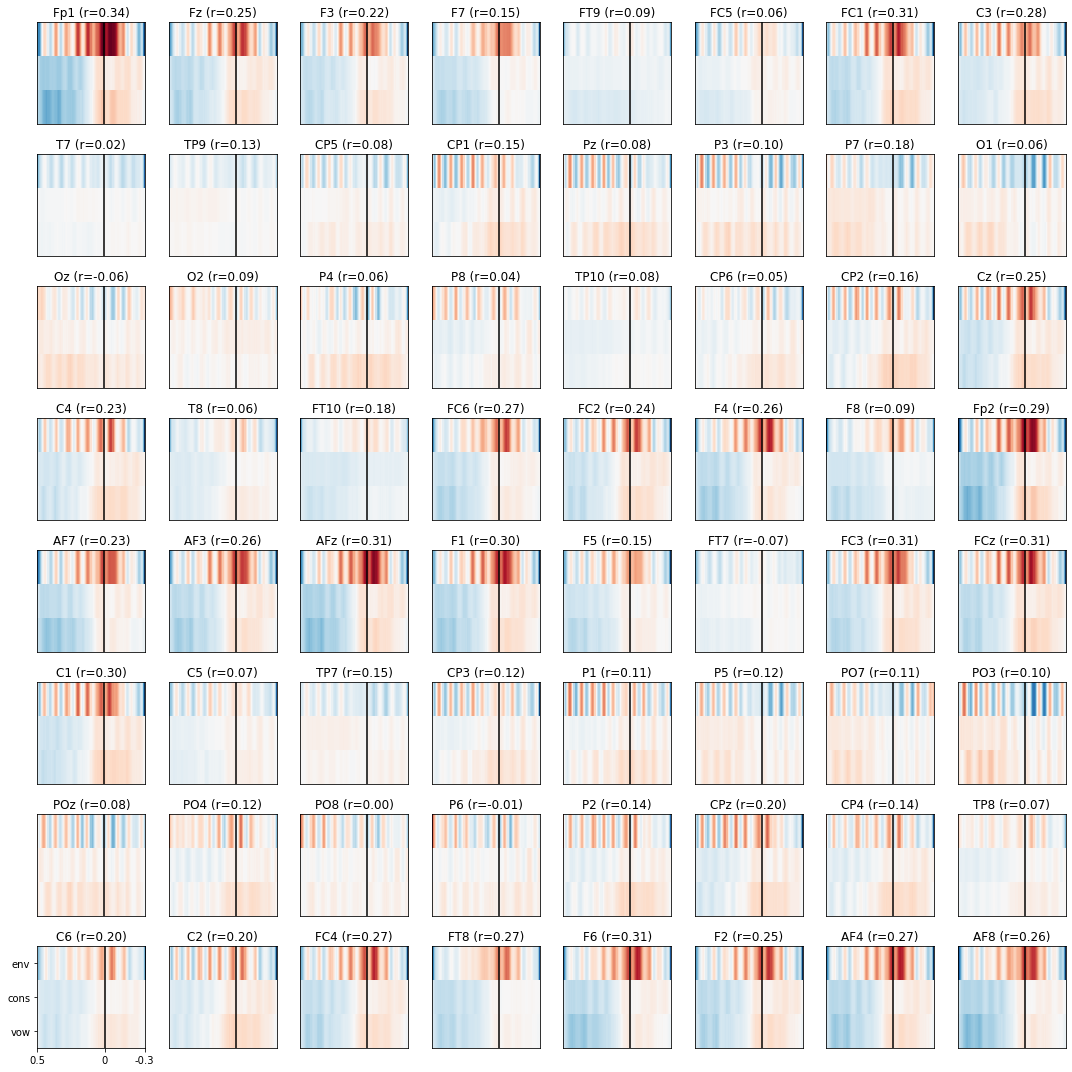

In [17]:
# Reshape weights to delays x feats x chans
rwts = wts[0].reshape(-1,stim.shape[1],resp.shape[1])
# Plot weights by channel
fig = plt.figure(figsize=(15,15))
wtmax = np.abs(rwts).max()*0.6
for i in np.arange(resp.shape[1]): # Loop through each channel
    ch_name = raw.info['ch_names'][i]
    plt.subplot(8,8,i+1)
    plt.imshow((rwts[:,:,i]).T, vmin=-wtmax, vmax=wtmax, aspect="auto", cmap=cm.RdBu_r, interpolation="nearest")
    plt.title("%s (r=%.2f)" % (ch_name, corrs[0][i]))
    if i == 56: # Bottom left
        plt.gca().set_yticks(np.arange(rwts.shape[1]))
        plt.gca().set_yticklabels(features)
        plt.gca().set_xticks([0,128*-delay_min,len(delays)])
        plt.gca().set_xticklabels([delay_min,0,delay_max]) 
    else: # Don't label the axes for the other plots, just to save space since theyre all the same ya know
        plt.gca().set_yticks([])
        plt.gca().set_xticks([])
    plt.gca().invert_xaxis()
    plt.axvline(128*-delay_min,color='k')
    plt.tight_layout();

## Testing for significance

This notebook is already pretty long, so I've left this out! A simple example of how to do this can be found in my thesis code [here](https://github.com/HamiltonLabUT/onsetProd/blob/master/ecog/strf/bootstrapping.ipynb) -- look at cell 4.

:)